<a href="https://colab.research.google.com/github/mariahelenass/Computer-Vision/blob/main/projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pipeline inicial
### Modelo pré treinado do torchgeo - ResNet18 Sentinel 2 RGB MOCO

In [ ]:
import torch
from torchgeo.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import ImageFile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
train = "/Users/mariahelena/Downloads/projetovisaocomp/train"
valid   = "/Users/mariahelena/Downloads/projetovisaocomp/valid"
test  = "/Users/mariahelena/Downloads/projetovisaocomp/test"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [ ]:
weights = ResNet18_Weights.SENTINEL2_RGB_MOCO

In [ ]:
train_dataset = datasets.ImageFolder(train, transform=transform)
valid_dataset = datasets.ImageFolder(valid, transform=transform)
test_dataset  = datasets.ImageFolder(test,  transform=transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

In [ ]:
model = resnet18(weights=weights)

In [ ]:
# congelando camadas
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# substituindo a ultima camada para o problema atual
classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, classes)

for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, rotulos in train_loader:
        images, rotulos = images.to(device), rotulos.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, rotulos)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == rotulos).sum().item()
        total += rotulos.size(0)

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # Validação
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, rotulos in valid_loader:
            images, rotulos = images.to(device), rotulos.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == rotulos).sum().item()
            val_total += rotulos.size(0)
    val_acc = 100 * val_correct / val_total

    # Resultado
    print(f"Época {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

Época 1/10 | Loss: 0.2690 | Train Acc: 92.30% | Val Acc: 94.14%
Época 2/10 | Loss: 0.1742 | Train Acc: 93.58% | Val Acc: 94.73%
Época 3/10 | Loss: 0.1579 | Train Acc: 94.08% | Val Acc: 95.11%
Época 4/10 | Loss: 0.1508 | Train Acc: 94.30% | Val Acc: 95.21%
Época 5/10 | Loss: 0.1433 | Train Acc: 94.69% | Val Acc: 95.43%
Época 6/10 | Loss: 0.1407 | Train Acc: 94.72% | Val Acc: 95.59%
Época 7/10 | Loss: 0.1378 | Train Acc: 94.94% | Val Acc: 95.35%
Época 8/10 | Loss: 0.1365 | Train Acc: 94.96% | Val Acc: 95.49%
Época 9/10 | Loss: 0.1332 | Train Acc: 95.04% | Val Acc: 95.70%
Época 10/10 | Loss: 0.1310 | Train Acc: 95.21% | Val Acc: 95.70%


In [ ]:
acertos, total = 0, 0
with torch.no_grad():
    for images, rotulos in test_loader:
        images, rotulos = images.to(device), rotulos.to(device)
        preds = model(images).argmax(1)
        acertos += (preds == rotulos).sum().item()
        total += rotulos.size(0)
print(f"Acurácia no teste: {100 * acertos / total:.2f}%")

Acurácia no teste: 96.78%


In [ ]:
model.eval()

predicoes = []
rotulos = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predicoes.extend(preds.cpu().numpy())
        rotulos.extend(labels.cpu().numpy())

predicoes = np.array(predicoes)
rotulos = np.array(rotulos)

class_labels = test_loader.dataset.classes

cm = confusion_matrix(rotulos, predicoes)

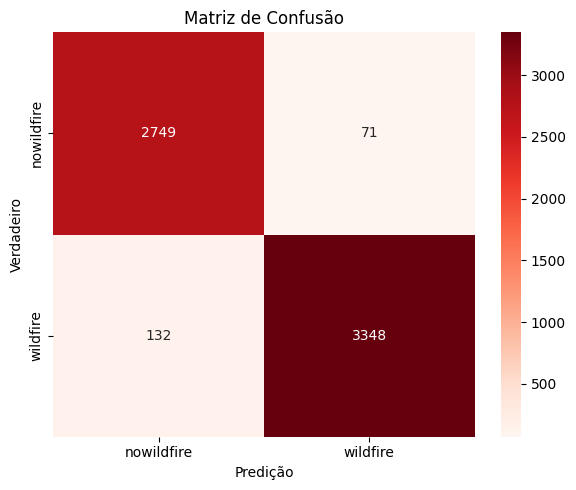

Relatório de classificação:

              precision    recall  f1-score   support

  nowildfire       0.95      0.97      0.96      2820
    wildfire       0.98      0.96      0.97      3480

    accuracy                           0.97      6300
   macro avg       0.97      0.97      0.97      6300
weighted avg       0.97      0.97      0.97      6300



In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.show()

print("Relatório de classificação:\n")
print(classification_report(rotulos, predicoes, target_names=class_labels))